In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [4]:
import logging as l

l.basicConfig(level=l.INFO)

In [5]:
dataset = dconst.AMAZON_PHOTO

spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 200.0,
    },}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        # 'use_dataset_registry' : False,
    },
    # **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
config_norm = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        # 'use_dataset_registry' : False,
    },
    **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    configuration.update_with_default_configuration(config_norm)
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default all
INFO:root:Set configuration value data.corpus_labels to default all
INFO:root:Set configuration value data.train_labels to default all
INFO:root:Set configuration value data.left_out_class_labels to default ['Film Photography', 'Binoculars & Scopes', 'Video Surveillance']
INFO:root:Set configuration value data.preprocessing to default none
INFO:root:Set configuration value data.ood_sampling_strategy to default all
INFO:root:Set configuration value data.train_portion to default 20
INFO:root:Set configuration value data.test_portion_fixed to default 0.2
INFO:root:Set configuration value data.split_type to default uniform
INFO:root:Set configuration value data.type to default npz
INFO:root:Set configuration value data.drop_train_vertices_portion to default 0.1
INFO:root:Set configuration value data.precompute_k_hop_neighbourhood to default 2
INFO:root:Set configuration value model.hidden_sizes to default [64]
INFO:root:Set 

True


In [6]:
config.data.setting

'hybrid'

In [7]:
if torch.cuda.is_available():
    config.training.gpus = 1
    config_norm.training.gpus = 1
    
config.training.gpus = 0
config_norm.training.gpus = 0
    

In [8]:
config.run.use_pretrained_model = False
config_norm.run.use_pretrained_model = True

In [9]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

INFO:root:Found precomputed dataset split at /nfs/students/fuchsgru/dataset_registry/3384787171.pt
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
model_seed = next(model_seed_generator)

In [11]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'continuous-distribution-shift')

In [12]:
class LoggingCallback(pl.callbacks.Callback):
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.global_step % 100 != 0:
            return
        
        l.info(' '.join(
            map(str, ['Epoch', trainer.global_step, 'acc', (pl_module(batch).get_predictions()[batch.mask].argmax(1) == batch.y[batch.mask]).float().mean().item()])
        
        ))
        

In [13]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None, callbacks=[LoggingCallback()]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Starting model training.

  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 48.2 K
----------------------------------
48.2 K    Trainable params
0         Non-trainable params
48.2 K    Total params
0.193     Total estimated model params size (MB)


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=8, bias=False)
          )
      )
    )
  )
)


Global seed set to 1952926171
INFO:root:Epoch 0 acc 0.13750000298023224
INFO:root:Epoch 100 acc 0.8374999761581421
INFO:root:Epoch 200 acc 0.9375
INFO:root:Epoch 300 acc 0.9437500238418579
INFO:root:Epoch 400 acc 0.949999988079071
INFO:root:Epoch 500 acc 0.9624999761581421
INFO:root:Epoch 600 acc 0.9624999761581421
INFO:root:Epoch 700 acc 0.9750000238418579
INFO:root:Epoch 800 acc 0.9750000238418579
INFO:root:Epoch 900 acc 0.9750000238418579
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/2823847966.ckpt'] were overwritten with /nfs/students/fuchsgru/model_registry/5886003145606701576-1651271183-3392045-3886667168.ckpt (copied from /nfs/students/fuchsgru/artifacts/continuous-distribution-shift/epoch=999-step=999-v1.ckpt).
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/5886003145606701576-1651271183-3392045-3886667168.ckpt.


In [42]:
np.linalg.svd(model.get_weights()['backbone.conv0.lin.weight'].cpu().detach().numpy(), full_matrices=False)[1]

array([9.61835098e+00, 8.64434719e+00, 8.08834362e+00, 7.14527130e+00,
       6.06789160e+00, 5.49447536e+00, 3.59349704e+00, 2.97932887e+00,
       3.91027629e-01, 3.54539037e-01, 2.71906137e-01, 2.30264291e-01,
       2.00370371e-01, 1.92394152e-01, 1.79564536e-01, 1.68607399e-01,
       1.58679590e-01, 1.42780647e-01, 1.32095665e-01, 1.15810141e-01,
       1.13898821e-01, 1.07948229e-01, 9.83391851e-02, 9.71448645e-02,
       8.75735506e-02, 8.26279819e-02, 7.74636269e-02, 7.52003938e-02,
       7.32556880e-02, 6.91964254e-02, 6.59030378e-02, 6.37554154e-02,
       5.72066829e-02, 5.48152216e-02, 5.36872186e-02, 5.09456545e-02,
       4.90062572e-02, 4.55546491e-02, 4.32344265e-02, 4.24290597e-02,
       4.05289382e-02, 4.00489010e-02, 3.74248065e-02, 3.71417738e-02,
       3.48602831e-02, 3.22748460e-02, 3.15672606e-02, 3.03447377e-02,
       2.82082520e-02, 2.76059769e-02, 2.72703730e-02, 2.64063273e-02,
       2.37345286e-02, 2.10132208e-02, 2.00135354e-02, 1.93614680e-02,
      

In [43]:
config_norm.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model_norm = make_model(config_norm, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model_norm)
model_norm = train_model(model_norm, config_norm, artifact_dir, data_loaders, logger=None, callbacks=[LoggingCallback()]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): ResidualBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): ParametrizedLinear(
              in_features=745, out_features=64, bias=False
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): SpectralNorm(rescaling=200.0, n_iter=1)
                )
              )
            )
          )
        (act): LeakyReLU(negative_slope=0.01)
        (input_projection): LinearWithParametrization(
          (linear): ParametrizedLinear(
            in_features=745, out_features=64, bias=False
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): SpectralNorm(rescaling=200.0, n_iter=1)
              )
            )
          )
        )
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Line

INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3051766037.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3051766037.ckpt.


In [44]:
model = model.cpu()
model_norm = model_norm.cpu()

In [45]:
# Check accuracy of both models
with torch.no_grad():
    data_val = data_dict[dconst.VAL][0]
    pred_val = model(data_val)
    pred_val_norm = model_norm(data_val)
    
    acc_val = (pred_val.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()
    acc_val_norm = (pred_val_norm.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()

    print(acc_val, acc_val_norm)

tensor(0.9500) tensor(0.9438)


In [46]:
(pred_val.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()

tensor(0.9500)

In [47]:
np.linalg.svd(model.get_weights()['backbone.conv0.lin.weight'].cpu().detach().numpy(), full_matrices=False)[1]

array([9.61835098e+00, 8.64434719e+00, 8.08834362e+00, 7.14527130e+00,
       6.06789160e+00, 5.49447536e+00, 3.59349704e+00, 2.97932887e+00,
       3.91027629e-01, 3.54539037e-01, 2.71906137e-01, 2.30264291e-01,
       2.00370371e-01, 1.92394152e-01, 1.79564536e-01, 1.68607399e-01,
       1.58679590e-01, 1.42780647e-01, 1.32095665e-01, 1.15810141e-01,
       1.13898821e-01, 1.07948229e-01, 9.83391851e-02, 9.71448645e-02,
       8.75735506e-02, 8.26279819e-02, 7.74636269e-02, 7.52003938e-02,
       7.32556880e-02, 6.91964254e-02, 6.59030378e-02, 6.37554154e-02,
       5.72066829e-02, 5.48152216e-02, 5.36872186e-02, 5.09456545e-02,
       4.90062572e-02, 4.55546491e-02, 4.32344265e-02, 4.24290597e-02,
       4.05289382e-02, 4.00489010e-02, 3.74248065e-02, 3.71417738e-02,
       3.48602831e-02, 3.22748460e-02, 3.15672606e-02, 3.03447377e-02,
       2.82082520e-02, 2.76059769e-02, 2.72703730e-02, 2.64063273e-02,
       2.37345286e-02, 2.10132208e-02, 2.00135354e-02, 1.93614680e-02,
      

In [48]:
torch.allclose(pred_val.get_predictions() , pred_val_norm.get_predictions())

False

In [49]:
from data.transform import PerturbationTransform

In [50]:
data_train = data_dict[dconst.TRAIN][0]
data_val = data_dict[dconst.VAL][0]

In [51]:
# The ground truth is used for fitting labeled data (train and val)
gnd_binary = torch.zeros(data_train.x.size(0), int(data_train.y.max() + 1))
gnd_binary[torch.arange(gnd_binary.size(0)), data_train.y] = 1

gnd_binary.sum(1)

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [52]:
with torch.no_grad():
    pred_train = model(data_train)
    pred_val = model(data_val)
    density_model = get_density_model(
        density_type='GaussianPerClass',
        covariance='diag',
        regularization=False,
        fit_val=True,
    )
    density_model.fit(
        pred_train.get_features(-2)[data_train.mask], 
        gnd_binary[data_train.mask], 
        pred_val.get_features(-2)[data_val.mask],
        gnd_binary[data_val.mask], 
    )

In [53]:
with torch.no_grad():
    pred_train_norm = model_norm(data_train)
    pred_val_norm = model_norm(data_val)
    density_model_norm = get_density_model(
        density_type='GaussianPerClass',
        covariance='diag',
        regularization=False,
        fit_val=False,
    )
    density_model_norm.fit(
        pred_train_norm.get_features(-2)[data_train.mask], 
        gnd_binary[data_train.mask], 
        pred_val_norm.get_features(-2)[data_val.mask],
        gnd_binary[data_val.mask], 
    )
    
density_model_norm(pred_train_norm.get_features(-2)[data_train.mask])
    

tensor([-167.5988, -170.7454, -187.2650, -173.1944, -186.8904, -197.0773,
        -183.9324, -181.0233, -198.8462, -196.2081, -185.7120, -187.0518,
        -187.2503, -192.7608, -183.5742, -181.0770, -168.0379, -197.7610,
        -211.9590, -185.8196, -175.8607, -192.1061, -193.1519, -171.9659,
        -197.8108, -212.8732, -176.3427, -193.4125, -181.9318, -184.2325,
        -189.4655, -184.3484, -181.8569, -194.9815, -177.8025, -174.6832,
        -195.4843, -191.9333, -191.8310, -176.6481, -187.8782, -199.6183,
        -203.2027, -204.7942, -185.1157, -168.2088, -188.9619, -185.9086,
        -187.0788, -196.7293, -187.9102, -195.1065, -178.4157, -181.9879,
        -191.5050, -193.7805, -189.3575, -206.7380, -191.5333, -188.4653,
        -167.9071, -185.7173, -182.3728, -187.0974, -186.1440, -183.6386,
        -195.8953, -198.9683, -193.1137, -200.8215, -181.6346, -191.4072,
        -185.8777, -191.2437, -196.5421, -200.2326, -189.7734, -203.1969,
        -196.2563, -197.2505, -192.575

In [54]:
model

SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=8, bias=False)
          )
      )
    )
  )
)

In [55]:
model.clear_and_disable_cache()
model_norm.clear_and_disable_cache()

INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


# Latent space plots vs p

In [56]:
# Get UMAP projections
from plot.density import *

In [57]:
from copy import deepcopy

In [58]:
features_p_ood, features_p_ood_norm = [], []
alea_p_ood, alea_p_ood_norm = [], []
ps_ood = []

with torch.no_grad():
    data_base = data_loaders[dconst.OOD_TEST].dataset[0]
    
    pred_id, pred_id_norm = model(data_base), model_norm(data_base)
    features_id = pred_id.get_features(-2)[data_base.mask & ~data_base.is_out_of_distribution].cpu().numpy()
    features_id_norm = pred_id_norm.get_features(-2)[data_base.mask & ~data_base.is_out_of_distribution].cpu().numpy()
    alea_id = pred_id.get_predictions().max(dim=1)[0].cpu().numpy()
    alea_id_norm = pred_id_norm.get_predictions().max(dim=1)[0].cpu().numpy()
    
    for p in tqdm(np.linspace(0, 1.0, 20)):
        
        data_p = PerturbationTransform(noise_type='bernoulli', p=p, seed=np.random.randint(0xFFFFFF))(data_base)
        with torch.no_grad():
            
            pred_p = model(deepcopy(data_p), remove_edges=False)
            pred_p_norm = model_norm(deepcopy(data_p), remove_edges=False)
            
            features_p_ood.append(
                pred_p.get_features(-2)[data_p.mask & data_base.is_out_of_distribution].cpu().numpy()
            )
            features_p_ood_norm.append(
                pred_p_norm.get_features(-2)[data_p.mask & data_p.is_out_of_distribution].cpu().numpy()
            )
            ps_ood.append((data_p.x > 0).float().mean(1)[data_p.mask & data_p.is_out_of_distribution])
            
            alea_p_ood.append(pred_p.get_predictions().max(dim=1)[0][data_p.mask & data_p.is_out_of_distribution])
            alea_p_ood_norm.append(pred_p_norm.get_predictions().max(dim=1)[0][data_p.mask & data_p.is_out_of_distribution])
            
            
features_p_ood, features_p_ood_norm = np.concatenate(features_p_ood), np.concatenate(features_p_ood_norm)
alea_p_ood, alea_p_ood_norm = np.concatenate(alea_p_ood),np.concatenate(alea_p_ood_norm) 
ps_ood = np.concatenate(ps_ood)

100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


In [59]:
features_fit = torch.cat([pred_train.get_features(-2)[data_train.mask], pred_val.get_features(-2)[data_val.mask]]).cpu().numpy()
features_fit_norm = torch.cat([pred_train_norm.get_features(-2)[data_train.mask], pred_val_norm.get_features(-2)[data_val.mask]]).cpu().numpy()

In [60]:
embs, is_fit, grids, grid_inverses = get_dimensionality_reduction_to_plot(
    features_fit, features_p_ood, ['umap']
)

In [61]:
embs_norm, is_fit_norm, grids_norm, grid_inverses_norm = get_dimensionality_reduction_to_plot(
    features_fit_norm, features_p_ood_norm, ['umap']
)

In [62]:
nx, ny = grids['umap'].shape[0], grids['umap'].shape[1]
density_grid = density_model(torch.from_numpy(grid_inverses['umap'].reshape(nx * ny, -1))).cpu().numpy().reshape((nx, ny))

In [63]:
nx, ny = grids_norm['umap'].shape[0], grids_norm['umap'].shape[1]
density_grid_norm = density_model_norm(torch.from_numpy(grid_inverses_norm['umap'].reshape(nx * ny, -1))).cpu().numpy().reshape((nx, ny))

In [64]:
density_id = density_model(torch.from_numpy(features_id))
density_id_norm = density_model_norm(torch.from_numpy(features_id_norm))

In [65]:
density_ood = density_model(torch.from_numpy(features_p_ood))
density_ood_norm = density_model_norm(torch.from_numpy(features_p_ood_norm))

In [66]:
from util import is_outlier

In [67]:
def binned_xy(x, y, n=10):
    
    bin_centers = np.linspace(0, 1, n + 1)
    bin_idxs = np.argmin(np.abs(x[:, None] - bin_centers[None, :]), axis=1)
    
    xr, yr, sr = [], [], []
    mins, maxs = [], []
    for bin_idx in range(bin_centers.shape[0]):
        idxs = bin_idxs == bin_idx
        if idxs.sum() > 0:
            xr.append(bin_centers[bin_idx])
            yr.append(y[idxs].mean())
            sr.append(y[idxs].std())
            mins.append(y[idxs].min())
            maxs.append(y[idxs].max())
    return np.array(xr), np.array(yr), np.array(sr), np.array(mins), np.array(maxs)

[-250. -216. -182. -148. -114.  -80.  -46.  -12.   22.   56.   90.]
[ 0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80.]
[-220. -215. -210. -205. -200. -195. -190. -185. -180. -175. -170.]
thesis_nbs/continuous_distribution_shift_plots/amazon_photo-latent.pdf


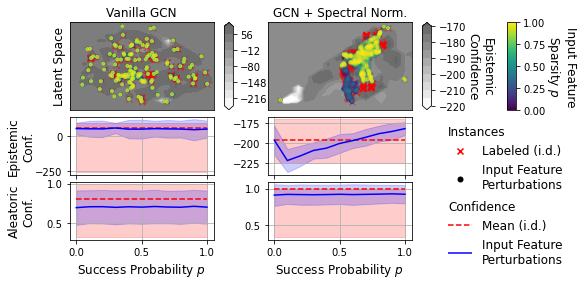

In [68]:
import matplotlib.colors as mc

cmap_arr = np.ones((256, 4))
cmap_arr[:, :3] *= np.linspace(1, 0.4, 256)[:, None]
cmap = mc.ListedColormap(cmap_arr)

fig, axs2 = plt.subplots(3, 7, figsize=(8,4), gridspec_kw={
    'wspace' : 0.2, 'hspace' : 0.1, 'width_ratios' : [0.8, 0.05, 0.07, 0.8, 0.05, 0.3, 0.05],
    'height_ratios' : [0.3, 0.2, 0.2],
})

axs = axs2[:, [0, 3, 4, 5, 6]]

def conf_int(x, conf=.95):
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    s = x.copy().reshape((-1, ))
    s.sort()
    first = int(s.shape[0] * (1 - conf) / 2)
    last = int(s.shape[0] * (conf + (1 - conf) / 2))
    return s[first], s[last]
    

def limits_to_levels(x, res=10, n=10, conf=.95):
    vmin, vmax = conf_int(x, conf=conf)
    vmin = int(vmin / res)
    vmax = int(vmax / res)
    return res * np.linspace(vmin, vmax, n + 1)

print(limits_to_levels(density_id))
print(limits_to_levels(density_grid))
print(limits_to_levels(density_id_norm))

c = axs[0, 0].contourf(grids['umap'][..., 0], grids['umap'][..., 1], density_grid,
                 cmap=cmap, 
                       levels=limits_to_levels(density_id), 
                       extend='both')
for cnt in c.collections:
    cnt.set_edgecolor("face")
axs[0, 0].scatter(embs['umap'][:, 0][is_fit], embs['umap'][:, 1][is_fit], marker='x', alpha=.2, c='red', rasterized=True)
axs[0, 0].scatter(embs['umap'][:, 0][~is_fit], embs['umap'][:, 1][~is_fit], marker='.', alpha=.2, c=ps_ood, rasterized=True)
cbar = fig.colorbar(c, ax=axs[0, 0], cax=axs2[0, 1])
#cbar = fig.colorbar(c, ax=axs[0, 0])
#cbar.set_label('Log Density', fontsize=12, rotation=270, labelpad=15)

c = axs[0, 1].contourf(grids_norm['umap'][..., 0], grids_norm['umap'][..., 1], density_grid_norm,
                 cmap=cmap, levels=limits_to_levels(density_id_norm), extend='both')
for cnt in c.collections:
    cnt.set_edgecolor("face")
axs[0, 1].scatter(embs_norm['umap'][:, 0][is_fit_norm], embs_norm['umap'][:, 1][is_fit_norm], marker='x', alpha=.2, c='red',rasterized=True)
axs[0, 1].scatter(embs_norm['umap'][:, 0][~is_fit_norm], embs_norm['umap'][:, 1][~is_fit_norm], marker='.', alpha=.2, c=ps_ood, rasterized=True)
cbar = fig.colorbar(c, ax=axs[0, 1], cax=axs[0, 2])
cbar.set_label('Epistemic\nConfidence', fontsize=12, rotation=270, labelpad=28)


density_id_min, density_id_max = conf_int(density_id)
axs[1, 0].plot([0, 1], [density_id.median().item()] * 2, color='red', ls='--')
axs[1, 0].fill_between([0, 1], [density_id_min] * 2, 
                       [density_id_max] * 2, color='red', alpha = .2)

axs[1, 0].set_xlim(-.05, 1.05)
xs, ms, stds, mins, maxs = binned_xy(ps_ood, density_ood.numpy())
axs[1, 0].plot(xs, ms, color='blue')
axs[1, 0].fill_between(xs, ms-stds, ms+stds, color='blue', alpha=.2)


density_id_norm_min, density_id_norm_max = conf_int(density_id_norm)
axs[1, 1].plot([0, 1], [density_id_norm.median().item()] * 2, color='red', ls='--')
axs[1, 1].fill_between([0, 1], [density_id_norm_min] * 2, 
                       [density_id_norm_max] * 2, color='red', alpha = .2)

axs[1, 1].set_xlim(-.05, 1.05)
xs, ms, stds, mins, maxs = binned_xy(ps_ood, density_ood_norm.numpy())
axs[1, 1].plot(xs, ms, color='blue')
axs[1, 1].fill_between(xs, ms-stds, ms+stds, color='blue', alpha=.2)

c = axs[1, 1].scatter([-1] * 256, [density_ood_norm.numpy().mean()] * 256, c=np.linspace(0, 1, 256))
cbar = fig.colorbar(c, ax=axs[1, 1], cax=axs[0, 4])
cbar.set_label('Input Feature\nSparsity $p$', fontsize=12, rotation=270, labelpad=32)

# Aleatoric 
alea_id_min, alea_id_max = conf_int(alea_id)
axs[2, 0].plot([0, 1], [np.median(alea_id)] * 2, color='red', ls='--')
axs[2, 0].fill_between([0, 1], [alea_id_min] * 2, 
                       [alea_id_max] * 2, color='red', alpha = .2)

axs[2, 0].set_xlim(-.05, 1.05)
xs, ms, stds, mins, maxs = binned_xy(ps_ood, alea_p_ood)
axs[2, 0].plot(xs, ms, color='blue')
axs[2, 0].fill_between(xs, ms-stds, ms+stds, color='blue', alpha=.2)

alea_id_norm_min, alea_id_norm_max = conf_int(alea_id)
axs[2, 1].plot([0, 1], [np.median(alea_id_norm)] * 2, color='red', ls='--')
axs[2, 1].fill_between([0, 1], [alea_id_norm_min] * 2, 
                       [alea_id_norm_max] * 2, color='red', alpha = .2)

axs[2, 1].set_xlim(-.05, 1.05)
xs, ms, stds, mins, maxs = binned_xy(ps_ood, alea_p_ood_norm)
axs[2, 1].plot(xs, ms, color='blue')
axs[2, 1].fill_between(xs, ms-stds, ms+stds, color='blue', alpha=.2)


#axs[-1, -1].set_visible(False)

for ax in axs[1:, 2:].flatten():
    ax.set_visible(False)
axs[0, 3].set_visible(False)

for ax in axs[0].flatten():
    ax.set_xticks([])
for ax in axs[-1, :-1].flatten():
    ax.set_xlabel('Success Probability $p$', fontsize=12)
    #ax.set_title('Epistemic Confidence')
for ax in axs[1, :-1].flatten():
    ax.set_xticklabels([])
for ax in axs[1:].flatten():
    ax.grid(which='major', axis='both')
for ax in axs2[1:, [1, 2]].flatten():
    ax.set_visible(False)
axs2[0, 2].set_visible(False)
    
axs[0, 0].set_ylabel('Latent Space', fontsize=12)
axs[1, 0].set_ylabel('Epistemic\nConf.', fontsize=12, labelpad=0)
axs[2, 0].set_ylabel('Aleatoric\nConf.', fontsize=12, labelpad=11) #labelpad=11)
axs[0, 0].set_title('Vanilla GCN', fontsize=12)
axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=12)

# Legend
handles = []
handles.append(axs[-1, -1].scatter([-1], [-1], marker='x', c='red'))
handles.append(axs[-1, -1].scatter([-1], [-1], marker='.', c='black', s=100))
legend = fig.legend(handles, ['Labeled (i.d.)', 'Input Feature\nPerturbations'], 
                    bbox_to_anchor=(1.0, 0.56), title='Instances', loc='upper right', frameon=False, fontsize=12)
plt.setp(legend.get_title(),fontsize=12)
legend._legend_box.align = "left"


handles = []
handles.append(axs[-1, -1].hlines([-1], -2, -1, colors='red', ls='--'))
handles.append(axs[-1, -1].hlines([-1], -2, -1, colors='blue', ls='-'))
legend = fig.legend(handles, ['Mean (i.d.)', 'Input Feature\nPerturbations'], 
                    bbox_to_anchor=(1.0, 0.30), title='Confidence', loc='upper right', frameon=False, fontsize=12)
plt.setp(legend.get_title(),fontsize=12)
legend._legend_box.align = "left"
    
for ax in axs[0, :2].flatten():
    ax.set_yticks([])
path = f'thesis_nbs/continuous_distribution_shift_plots/{dataset}-latent.pdf'
fig.savefig(path, bbox_inches='tight', dpi=200)
print(path)

In [69]:
# Stop here
raise

RuntimeError: No active exception to reraise

In [ ]:
from copy import deepcopy

In [ ]:
aurocs_density, aurocs_max_score = [], []
aurocs_density_no_edges, aurocs_max_score_no_edges = [], []
aurocs_density_norm, aurocs_max_score_norm = [], []
aurocs_density_norm_no_edges, aurocs_max_score_norm_no_edges = [], []
ps = []

resolution = 50
k = 5

for p in tqdm(np.linspace(0.0, 1.0, resolution)):
    for _ in range(k):
        data_p = PerturbationTransform(noise_type='bernoulli', p=p, seed=np.random.randint(0xFFFFFF))(data_loaders[dconst.OOD_VAL].dataset[0])
        ps.append(p)
        with torch.no_grad():
            pred_p = model(deepcopy(data_p), remove_edges=False)
            pred_p_no_edges = model(deepcopy(data_p), remove_edges=True)
            pred_p_norm = model_norm(deepcopy(data_p), remove_edges=False)
            pred_p_norm_no_edges = model_norm(deepcopy(data_p), remove_edges=True)
            
            density_p = density_model(pred_p.get_features(-2))
            density_p_no_edges = density_model(pred_p_no_edges.get_features(-2))
            density_p_norm = density_model_norm(pred_p_norm.get_features(-2))
            density_p_norm_no_edges = density_model_norm(pred_p_norm_no_edges.get_features(-2))
            
            # Calculate AUROCs
            aurocs_density.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
            aurocs_density_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p_no_edges.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p_no_edges.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
            aurocs_density_norm.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p_norm.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_norm.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p_norm.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
            aurocs_density_norm_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p_norm_no_edges.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_norm_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p_norm_no_edges.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))

In [ ]:
from scipy.stats import binned_statistic

In [ ]:
# Get uncertainty intervals for all sucess probabilities p
ps = np.array(ps).reshape((-1, k))
means, stds = {}, {}

for key, vals in {
    'aurocs_density' : aurocs_density, 'aurocs_max_score' : aurocs_max_score,
    'aurocs_density_no_edges' : aurocs_density_no_edges, 'aurocs_max_score_no_edges' : aurocs_max_score_no_edges,
    'aurocs_density_norm' : aurocs_density_norm, 'aurocs_max_score_norm' : aurocs_max_score_norm,
    'aurocs_density_norm_no_edges' : aurocs_density_norm_no_edges, 'aurocs_max_score_norm_no_edges' : aurocs_max_score_norm_no_edges,
}.items():
    vals = np.array(vals).reshape((resolution, k))
    means[key] = vals.mean(axis=1)
    stds[key] = vals.std(axis=1)
    
    


In [ ]:



if dataset == dconst.CORA_FULL:
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 4), gridspec_kw = {
                           'height_ratios' : [1, 1, 0.6], 'wspace' : 0.2, 'hspace' : .95
    })

    def plot_proxy_at(key, ax, color, label):
        handle = ax.plot(ps[:, 0], means[key], color=color, label=label, linestyle='--')
        ax.fill_between(ps[:, 0], means[key] - stds[key], means[key] + stds[key], alpha = 0.2, color=color)
        return handle


    plot_proxy_at('aurocs_density', axs[0, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score', axs[0, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm', axs[0, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm', axs[0, 1], 'tab:orange', 'Aleatoric')

    plot_proxy_at('aurocs_density_no_edges', axs[1, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_no_edges', axs[1, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm_no_edges', axs[1, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm_no_edges', axs[1, 1], 'tab:orange', 'Aleatoric')

    handles = []
    handles += axs[-2, -1].plot([], [], color='tab:blue', label='Epistemic', linestyle='--')
    handles += axs[-2, -1].plot([], [], color='tab:orange', label='Aleatoric', linestyle='--')

    for ax in axs[:-1, :].flatten():
        ax.grid(which='major')
    for ax in axs[-1, :].flatten():
        ax.grid(which='major', axis='x')

    nnzs = (data_train.x.detach().cpu() > 0).float().mean(1).numpy()
    axs[2, 0].hist(nnzs, bins=10)
    axs[2, 0].set_yscale('log')
    axs[2, 1].hist(nnzs, bins=10)
    axs[2, 1].set_yscale('log')

    axs[0, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[2, 0].set_ylabel('Count', fontsize=12)
    axs[2, 0].set_xlabel('Input Feature Density $p$', fontsize=12)
    axs[2, 1].set_xlabel('Input Feature Density $p$', fontsize=12)

    axs[0, 0].set_title('Vanilla GCN', fontsize=12)
    axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=12)
    axs[1, 0].set_title('Vanilla GCN, No Edges', fontsize=12)
    axs[1, 1].set_title('GCN + Spectral Norm., No Edges', fontsize=12)
    axs[2, 0].set_title('Input Feature Distribution,\nCoraML+OS', fontsize=12)
    axs[2, 1].set_title('Input Feature Distribution,\nCoraML+OS', fontsize=12)

    legend = fig.legend(handles, ['Epistemic', 'Aleatoric'], title='Proxy', loc='upper right', 
                        bbox_to_anchor=(1.13, 0.95), frameon=False, fontsize=12)
    plt.setp(legend.get_title(),fontsize=12)
    fig.savefig(f'thesis_nbs/continuous_distribution_shift_plots/{dataset}.pdf', bbox_inches='tight')

In [ ]:

if dataset == dconst.AMAZON_PHOTO:


    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 4), gridspec_kw = {
                           'height_ratios' : [1, 1, 0.6], 'wspace' : 0.2, 'hspace' : .95
    })

    def plot_proxy_at(key, ax, color, label):
        handle = ax.plot(ps[:, 0], means[key], color=color, label=label, linestyle='--')
        ax.fill_between(ps[:, 0], means[key] - stds[key], means[key] + stds[key], alpha = 0.2, color=color)
        return handle


    plot_proxy_at('aurocs_density', axs[0, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score', axs[0, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm', axs[0, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm', axs[0, 1], 'tab:orange', 'Aleatoric')

    plot_proxy_at('aurocs_density_no_edges', axs[1, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_no_edges', axs[1, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm_no_edges', axs[1, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm_no_edges', axs[1, 1], 'tab:orange', 'Aleatoric')

    handles = []
    handles += axs[-2, -1].plot([], [], color='tab:blue', label='Epistemic', linestyle='--')
    handles += axs[-2, -1].plot([], [], color='tab:orange', label='Aleatoric', linestyle='--')

    for ax in axs[:-1, :].flatten():
        ax.grid(which='major')
    for ax in axs[-1, :].flatten():
        ax.grid(which='major', axis='x')

    nnzs = (data_train.x.detach().cpu() > 0).float().mean(1).numpy()
    axs[2, 0].hist(nnzs, bins=10)
    axs[2, 0].set_yscale('log')
    axs[2, 1].hist(nnzs, bins=10)
    axs[2, 1].set_yscale('log')

    axs[0, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[2, 0].set_ylabel('Count', fontsize=12)
    axs[2, 0].set_xlabel('Input Feature Density $p$', fontsize=12)
    axs[2, 1].set_xlabel('Input Feature Density $p$', fontsize=12)

    axs[0, 0].set_title('Vanilla GCN', fontsize=12)
    axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=12)
    axs[1, 0].set_title('Vanilla GCN, No Edges', fontsize=12)
    axs[1, 1].set_title('GCN + Spectral Norm., No Edges', fontsize=12)
    axs[2, 0].set_title('Input Feature Distribution,\nAmazon Photos', fontsize=12)
    axs[2, 1].set_title('Input Feature Distribution,\nAmazon Photos', fontsize=12)

    axs[2, 0].set_yticks(axs[2, 0].get_yticks()[::2])
    axs[2, 1].set_yticks(axs[2, 1].get_yticks()[::2])
    axs[1, 0].set_yticklabels(['', '0.0', '1.0'])
    axs[1, 1].set_yticklabels(['', '0.0', '1.0'])

    legend = fig.legend(handles, ['Epistemic', 'Aleatoric'], title='Proxy', loc='upper right', bbox_to_anchor=(1.1, 0.9), frameon=False)
    plt.setp(legend.get_title(),fontsize=12)
    fig.savefig(f'thesis_nbs/continuous_distribution_shift_plots/{dataset}.pdf', bbox_inches='tight')

In [ ]:
if dataset == dconst.CITESEER:
    



    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 4), gridspec_kw = {
                           'height_ratios' : [1, 1, 0.6], 'wspace' : 0.2, 'hspace' : .95
    })

    def plot_proxy_at(key, ax, color, label):
        handle = ax.plot(ps[:, 0], means[key], color=color, label=label, linestyle='--')
        ax.fill_between(ps[:, 0], means[key] - stds[key], means[key] + stds[key], alpha = 0.2, color=color)
        return handle


    plot_proxy_at('aurocs_density', axs[0, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score', axs[0, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm', axs[0, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm', axs[0, 1], 'tab:orange', 'Aleatoric')

    plot_proxy_at('aurocs_density_no_edges', axs[1, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_no_edges', axs[1, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm_no_edges', axs[1, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm_no_edges', axs[1, 1], 'tab:orange', 'Aleatoric')

    handles = []
    handles += axs[-2, -1].plot([], [], color='tab:blue', label='Epistemic', linestyle='--')
    handles += axs[-2, -1].plot([], [], color='tab:orange', label='Aleatoric', linestyle='--')

    for ax in axs[:-1, :].flatten():
        ax.grid(which='major')
    for ax in axs[-1, :].flatten():
        ax.grid(which='major', axis='x')

    nnzs = (data_train.x.detach().cpu() > 0).float().mean(1).numpy()
    axs[2, 0].hist(nnzs, bins=10)
    axs[2, 0].set_yscale('log')
    axs[2, 1].hist(nnzs, bins=10)
    axs[2, 1].set_yscale('log')

    axs[0, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[2, 0].set_ylabel('Count', fontsize=12)
    axs[2, 0].set_xlabel('Input Feature Density $p$', fontsize=12)
    axs[2, 1].set_xlabel('Input Feature Density $p$', fontsize=12)

    axs[0, 0].set_title('Vanilla GCN', fontsize=12)
    axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=12)
    axs[1, 0].set_title('Vanilla GCN, No Edges', fontsize=12)
    axs[1, 1].set_title('GCN + Spectral Norm., No Edges', fontsize=12)
    axs[2, 0].set_title('Input Feature Distribution,\nCiteseer', fontsize=12)
    axs[2, 1].set_title('Input Feature Distribution,\nCiteseer', fontsize=12)
    
    axs[1, 0].set_yticklabels(['', '0.0', '1.0'])
    axs[1, 1].set_yticklabels(['', '0.0', '1.0'])

    legend = fig.legend(handles, ['Epistemic', 'Aleatoric'], title='Proxy', loc='upper right', 
                        bbox_to_anchor=(1.13, 0.95), 
               frameon=False, fontsize=12)
    plt.setp(legend.get_title(),fontsize=12)
    fig.savefig(f'thesis_nbs/continuous_distribution_shift_plots/{dataset}.pdf', bbox_inches='tight')